In [31]:
import mne 
import numpy as np
import os
import pyxdf

In [32]:
import pyxdf
import numpy as np
import mne

# List all XDF runs
runs = [
    r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot02\Cogwear\sub-Pilot02_ses-S001_task-Default_run-001_eeg.xdf',
    # r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot06\Cogwear\sub-P006\ses-S001\eeg\sub-P006_ses-S001_task-Default_run-002_eeg.xdf',
    # r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot06\Cogwear\sub-P006\ses-S001\eeg\sub-P006_ses-S001_task-Default_run-003_eeg.xdf',
    # r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot06\Cogwear\sub-P006\ses-S001\eeg\sub-P006_ses-S001_task-Default_run-004_eeg.xdf',
]

eeg_data_list = []
events_list = []

sfreq = None
ch_names = None
total_samples = 0  # for offset between runs

for run_idx, raw_data_path in enumerate(runs):
    print(f"\nLoading: {raw_data_path}")
    streams, header = pyxdf.load_xdf(raw_data_path)

    # Stream selection
    marker_stream = streams[0]  # PsychoPy_LSL
    eeg_stream = streams[1]     # Pilot02_cogwear

    # --- EEG data
    data = eeg_stream['time_series'].T  # (n_channels, n_samples)
    n_samples = data.shape[1]

    if sfreq is None:
        sfreq = float(eeg_stream['info']['nominal_srate'][0])

        desc = eeg_stream['info']['desc'][0] if eeg_stream['info']['desc'] else None
        if desc and 'channels' in desc[0] and 'channel' in desc[0]['channels'][0]:
            ch_names = [ch['label'][0] for ch in desc[0]['channels'][0]['channel']]
        else:
            ch_names = [f'EEG{i+1}' for i in range(data.shape[0])]
        print(f"Channel Names: {ch_names}")

    eeg_data_list.append(data)

    # --- Marker / Event data
    marker_times = np.array(marker_stream['time_stamps'])
    marker_values = [m[0] for m in marker_stream['time_series']]

    # Align marker timestamps to EEG
    start_time = eeg_stream['time_stamps'][0]
    event_samples = ((marker_times - start_time) * sfreq).astype(int)

    # Add offset for concatenated runs
    event_samples += total_samples

    # Build MNE-style events array
    events_run = np.array([[s, 0, val] for s, val in zip(event_samples, marker_values)])
    events_list.append(events_run)

    # Update total_samples for next run
    total_samples += n_samples

# Check channel counts for each run
for i, data in enumerate(eeg_data_list):
    print(f"Run {i} channels: {data.shape[0]}")

# --- Concatenate EEG data and events
eeg_data = np.concatenate(eeg_data_list, axis=1)
events = np.vstack(events_list)

print("\nFinal EEG shape:", eeg_data.shape)
print("First few events:\n", events[:10])

# --- Create Raw object (NO annotations)
info = mne.create_info(ch_names, sfreq, ch_types="eeg")
raw = mne.io.RawArray(eeg_data, info)

print("\n Finished: Raw EEG + events ready")



Loading: C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot02\Cogwear\sub-Pilot02_ses-S001_task-Default_run-001_eeg.xdf
Channel Names: ['EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8']
Run 0 channels: 8

Final EEG shape: (8, 162660)
First few events:
 [[ 9886     0    71]
 [ 9887     0    31]
 [ 9994     0     3]
 [10285     0    90]
 [10381     0    74]
 [10382     0    23]
 [10490     0    16]
 [10844     0    90]
 [10987     0    73]
 [10988     0    26]]
Creating RawArray with float64 data, n_channels=8, n_times=162660
    Range : 0 ... 162659 =      0.000 ...   650.636 secs
Ready.

 Finished: Raw EEG + events ready


In [91]:
raw.plot()


Channels marked as bad:
none


In [ ]:
# raw_data_path = r'D:\Priming_name\Pilot02_cogwear\sub-Pilot02\ses-S001\eeg\sub-Pilot02_ses-S001_task-Default_run-001_eeg.xdf'
# streams, header = pyxdf.load_xdf(raw_data_path)


In [ ]:
# for i, s in enumerate(streams):
#     print(f"Stream {i}: {s['info']['name'][0]}, {s['info']['type'][0]}, shape={s['time_series'].shape}")

Stream 0: PsychoPy_LSL, Markers, shape=(1598, 1)
Stream 1: Pilot02_cogwear, EEG, shape=(162660, 8)


In [ ]:
# eeg_stream = streams[1]  # Pilot02_cogwear
# marker_stream = streams[0]  # PsychoPy_LSL

# # --- 3. Prepare EEG data
# data = eeg_stream['time_series'].T  # shape (n_channels, n_samples)
# sfreq = float(eeg_stream['info']['nominal_srate'][0])
# # --- Try to get channel names ---
# desc = eeg_stream['info']['desc'][0] if eeg_stream['info']['desc'] else None

# if desc and 'channels' in desc[0] and 'channel' in desc[0]['channels'][0]:
#     ch_names = [ch['label'][0] for ch in desc[0]['channels'][0]['channel']]
# else:
#     # If no channel labels in file, create generic ones
#     n_channels = data.shape[0]
#     ch_names = [f'EEG{i+1}' for i in range(n_channels)]
# print(f"Channel names: {ch_names}")

Channel names: ['EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8']


In [ ]:
# # --- Create MNE Raw object ---
# info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
# raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=8, n_times=162660
    Range : 0 ... 162659 =      0.000 ...   650.636 secs
Ready.


In [33]:
# Marker data
marker_times = marker_stream['time_stamps']
marker_values = [m[0] for m in marker_stream['time_series']]

# Align marker timestamps to EEG
start_time = eeg_stream['time_stamps'][0]
event_samples = ((marker_times - start_time) * sfreq).astype(int)

# Keep original trigger values
events = np.array([[s, 0, val] for s, val in zip(event_samples, marker_values)])

print("First few events:", events[:10])



First few events: [[ 9886     0    71]
 [ 9887     0    31]
 [ 9994     0     3]
 [10285     0    90]
 [10381     0    74]
 [10382     0    23]
 [10490     0    16]
 [10844     0    90]
 [10987     0    73]
 [10988     0    26]]


In [34]:
n_times = raw.n_times
stim_data = np.zeros((1, n_times))

# Fill trigger channel with event codes
for sample, _, event_id in events:
    if sample < n_times:
        stim_data[0, sample] = event_id

# Create and add stim channel
stim_info = mne.create_info(['STI 014'], sfreq=raw.info['sfreq'], ch_types=['stim'])
stim_raw = mne.io.RawArray(stim_data, stim_info)

raw.add_channels([stim_raw])

# Map your active channels to the montage names
raw.rename_channels({
    'EEG1': 'AF8',
    'EEG2': 'Fp2',
    'EEG3': 'Fp1',
    'EEG4': 'AF7'
})

raw.drop_channels(['EEG5','EEG6','EEG7','EEG8'])

# Now save
# raw.save(raw_data_path.replace('.xdf', '-raw.fif'), overwrite=True)

Creating RawArray with float64 data, n_channels=1, n_times=162660
    Range : 0 ... 162659 =      0.000 ...   650.636 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"4 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [35]:
filt_raw = raw.filter(l_freq=1., h_freq=40.)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



In [36]:
montage_dict = {
    'AF8': [0.35, 0.12, 0.0],  # Right front
    'Fp2': [0.2, 0.1, 0.0],    # Right frontal pole
    'Fp1': [-0.2, 0.1, 0.0],   # Left frontal pole
    'AF7': [-0.35, 0.12, 0.0], # Left front
}

# Create the montage
montage = mne.channels.make_dig_montage(ch_pos=montage_dict, coord_frame='head')

# Assign the montage to your Raw object
filt_raw.set_montage(montage, match_case=False, on_missing='ignore')

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,7 points
Good channels,"4 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [22]:
print(filt_raw.ch_names)


['AF8', 'Fp2', 'Fp1', 'AF7', 'STI 014']


In [37]:
events = mne.find_events(raw, stim_channel='STI 014')


1421 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 71 72 73 74 90]


In [38]:
sfreq = raw.info['sfreq']
prim_codes = [71, 72, 73, 74]
face_codes = list(range(1, 21))

for code in prim_codes:
    prim_samples = events[events[:, 2] == code, 0]
    print(f"\nCode {code}:")
    for s in prim_samples[:5]:  # just look at first 5 trials per condition
        # find nearest face event (any 1–20)
        diffs = events[np.isin(events[:, 2], face_codes), 0] - s
        nearest_idx = np.argmin(np.abs(diffs))
        delay_ms = diffs[nearest_idx] / sfreq * 1000
        print(f"  nearest face = {events[np.isin(events[:, 2], face_codes)][nearest_idx, 2]}, delay = {delay_ms:.1f} ms")

new_trigger_offset = 100  # 71->171, 72->172, etc.
new_events = []

for prim_code in [71, 72, 73, 74]:
    prim_samples = events[events[:,2] == prim_code, 0]
    face_samples = events[np.isin(events[:,2], range(1,21)), 0]
    face_codes = events[np.isin(events[:,2], range(1,21)), 2]

    for s in prim_samples:
        # compute delays to all face triggers
        diffs = (face_samples - s).astype(float)  # <- convert to float
        diffs[diffs < 0] = np.inf  # ignore faces before the prime
        if np.all(diffs == np.inf):
            continue  # no future face found
        nearest_idx = np.argmin(diffs)
        face_sample = face_samples[nearest_idx]
        new_code = prim_code + new_trigger_offset
        new_events.append([face_sample, 0, new_code])

new_events = np.array(new_events, dtype=int)


Code 71:
  nearest face = 3, delay = 432.0 ms
  nearest face = 13, delay = 488.0 ms
  nearest face = 17, delay = 484.0 ms
  nearest face = 11, delay = 496.0 ms
  nearest face = 9, delay = 380.0 ms

Code 72:
  nearest face = 13, delay = 540.0 ms
  nearest face = 19, delay = 480.0 ms
  nearest face = 1, delay = 384.0 ms
  nearest face = 19, delay = 496.0 ms
  nearest face = 13, delay = 424.0 ms

Code 73:
  nearest face = 10, delay = 480.0 ms
  nearest face = 16, delay = 496.0 ms
  nearest face = 14, delay = 436.0 ms
  nearest face = 10, delay = 524.0 ms
  nearest face = 14, delay = 504.0 ms

Code 74:
  nearest face = 16, delay = 436.0 ms
  nearest face = 10, delay = 464.0 ms
  nearest face = 14, delay = 488.0 ms
  nearest face = 12, delay = 472.0 ms
  nearest face = 2, delay = 512.0 ms


In [39]:
combined_events = np.vstack([events, new_events])

# Sort chronologically
combined_events = combined_events[np.argsort(combined_events[:, 0])]

In [40]:
event_id = {
    'M-cong': 171,
    'M-incong': 172,
    'F-cong': 173,
    'F-incong': 174
}

epochs = mne.Epochs(
    raw,
    combined_events,
    event_id=event_id,
    tmin=-0.2,
    tmax=1.0,
    baseline=(-0.2, 0),
    event_repeated='drop',
    preload=True
)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
398 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 398 events and 301 original time points ...
0 bad epochs dropped


In [41]:
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
ica = ICA(n_components=4,method='picard', max_iter="auto", random_state=97)
# filt_raw.drop_channels(["EXG1", "EXG2"])
# filt_raw.drop_channels(['EEG5', 'EEG6', 'EEG7', 'EEG8'])
ica.fit(epochs)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


C:\Users\NARONG\AppData\Local\Temp\ipykernel_34988\468961516.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.5s.


Method,picard
Fit parameters,max_iter=500
Fit,21 iterations on epochs (119798 samples)
ICA components,4
Available PCA components,4
Channel types,eeg
ICA components marked for exclusion,—


In [42]:
ica.plot_sources(epochs, show_scrollbars=True)  # plot component signals
# ica.plot_properties(filt_raw, picks=[0, 1, 2, 3])  # detailed plots for components


Not setting metadata
398 matching events found
No baseline correction applied
0 projection items activated


In [43]:
ica.exclude = [0, 1]
ica.apply(epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 4 PCA components


C:\Users\NARONG\AppData\Local\Temp\ipykernel_34988\1085092278.py:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


Number of events,398
Events,F-cong: 99F-incong: 99M-cong: 100M-incong: 100
Time range,-0.200 – 1.000 s
Baseline,-0.200 – 0.000 s


In [ ]:
epochs['M-cong'].plot(picks=['AF8', 'Fp2', 'Fp1', 'AF7'])

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [87]:
congruent = mne.combine_evoked(
    [epochs['M-cong'].average(), epochs['F-cong'].average()],
    weights='equal'
)

incongruent = mne.combine_evoked(
    [epochs['M-incong'].average(), epochs['F-incong'].average()],
    weights='equal'
)

In [88]:
channels_of_interest = ['AF8', 'Fp2', 'Fp1', 'AF7']

In [89]:
evokeds_dict = {
    'congruent': congruent,
    'incongruent': incongruent
}

C:\Users\NARONG\AppData\Local\Temp\ipykernel_25588\2585107891.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


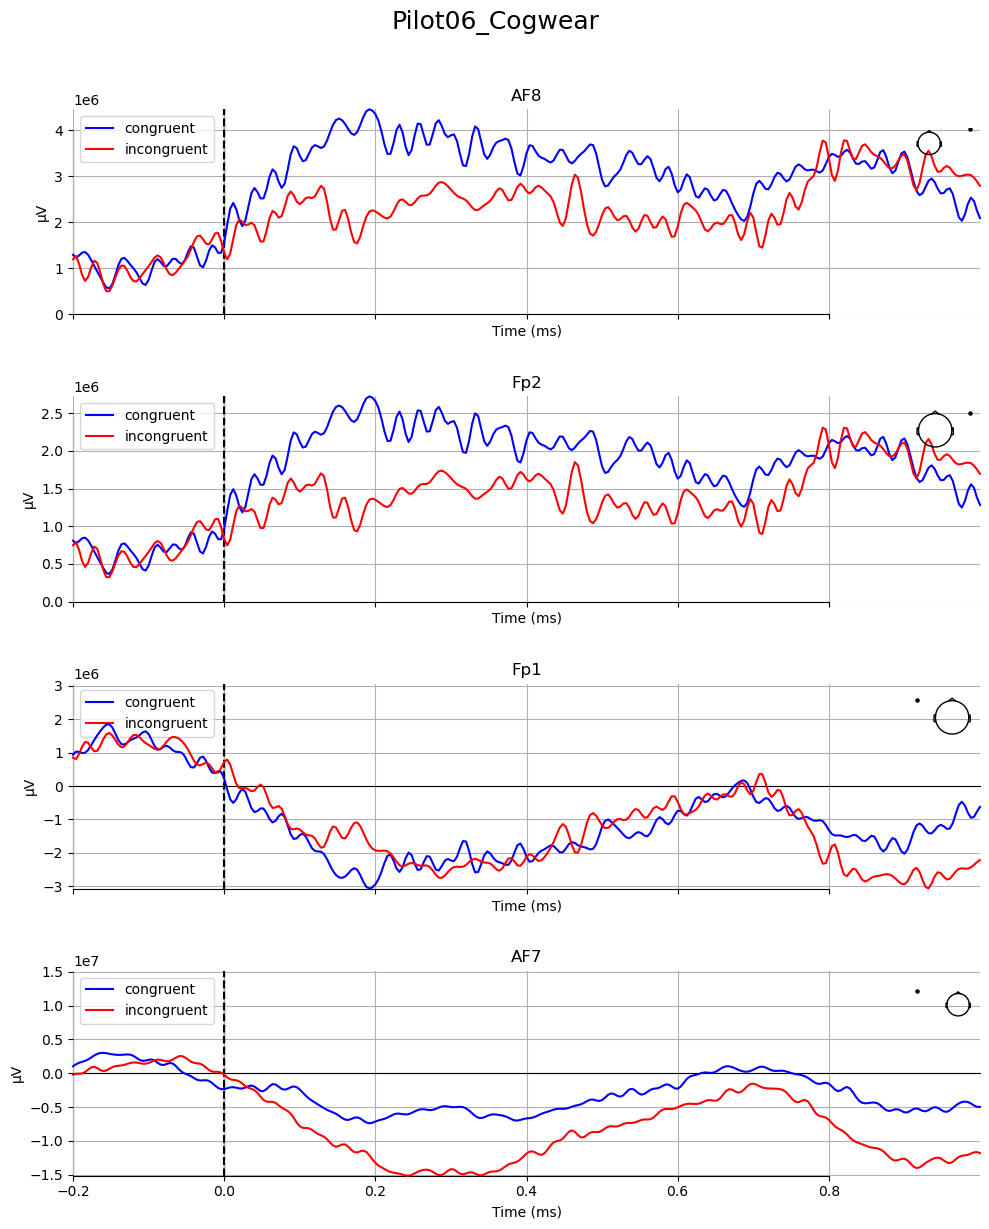

In [92]:
import matplotlib.pyplot as plt

n_channels = len(channels_of_interest)
fig, axes = plt.subplots(n_channels, 1, figsize=(10, 3*n_channels), sharex=True)

for i, ch in enumerate(channels_of_interest):
    mne.viz.plot_compare_evokeds(
        evokeds_dict,
        picks=[ch],
        axes=axes[i],
        colors={'congruent': 'blue', 'incongruent': 'red'},
        show=False
    )
    axes[i].set_title(ch)
    axes[i].set_xlim(incongruent.times[0], congruent.times[-1])
    axes[i].grid(True)

for ax in axes:
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (ms)')

fig.suptitle('Pilot06_Cogwear', fontsize=18, y=1.02)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
# folder = os.path.dirname(raw_data_path)
# basename = os.path.splitext(os.path.basename(raw_data_path))[0]

# ica_path = os.path.join(folder, f'{basename}-ica.fif')
# ica.save(ica_path, overwrite=True)

Writing ICA solution to D:\Priming_name\Pilot02_cogwear\sub-Pilot02\ses-S001\eeg\sub-Pilot02_ses-S001_task-Default_run-001_eeg-ica.fif...


Method,picard
Fit parameters,max_iter=500
Fit,11 iterations on epochs (30100 samples)
ICA components,4
Available PCA components,4
Channel types,eeg
ICA components marked for exclusion,ICA001ICA002
